In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score

In [25]:
import xgboost
from xgboost import XGBClassifier

In [26]:
train=pd.read_csv("./Data/Training_dataset_Original.csv", low_memory=False)
test=pd.read_csv("./Data/Leaderboard_dataset.csv", low_memory=False)

In [27]:
def replace_nan(data):
    data = data.replace("nan", np.nan)
    data = data.replace("missing", np.nan)
    data = data.replace("na", np.nan)
    return data

In [28]:
train = replace_nan(train)
test = replace_nan(test)

In [29]:
def fill_data(data):
    data['mvar47'] = data['mvar47'] == 'C'
    data = data.astype(dtype='float64')
#     data = data.fillna(data.median())
#     data = data.fillna(data.mean())
    return data

In [30]:
train = fill_data(train)
test = fill_data(test)

In [31]:
# data=pd.concat([train, test], sort=False)
# data=pd.concat([train.drop('default_ind', axis=1), test])

In [32]:
skewed = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 
          'mvar8', 'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13', 
          'mvar14', 'mvar15', 'mvar16', 'mvar17', 'mvar18', 'mvar19', 
          'mvar20', 'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 
          'mvar39', 'mvar42', 'mvar43', 'mvar44', 'mvar45', 'mvar46']

# skewed = ['mvar2', 'mvar3', 'mvar6', 'mvar7', 'mvar9', 'mvar10', 
#           'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15', 'mvar16',
#           'mvar19', 'mvar32', 'mvar33', 'mvar34', 'mvar36', 
#           'mvar39', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [33]:
for i in skewed:
    train[i] = train[i].fillna(train[i].median())
    test[i] = test[i].fillna(test[i].median())

for i in range(1, 48):
    t = "mvar"+str(i)
    if not t in skewed:
#         print(t)
        train = train.astype(dtype='float64')
        test = test.astype(dtype='float64')
        train[t] = train[t].fillna(train[t].mean())
        test[t] = test[t].fillna(test[t].mean())

In [34]:
# def normalizing(X):
#     data[X][data[X] < 0]=0
#     data[X][data[X] > data[X].quantile(0.99)] = data[X].quantile(0.99)
#     data[X] = data[X].apply(lambda x: x+np.random.rand())
    
#     data[X] = data[X].apply(lambda x: x+1)
#     data[X], _ = boxcox(data[X])

# for i in skewed:
#     normalizing(i)

In [35]:
def feature_engineer(data):
    data = data.drop(['mvar4', 'mvar5'], axis = 1)
    
    data['mvar7'] = data['mvar7']+data['mvar8']
    data = data.drop(['mvar8'], axis = 1)
    
    data['mvar16'] = data['mvar16']+data['mvar17']+data['mvar18']
    data = data.drop(['mvar17', 'mvar18'], axis = 1)
    
    data['mvar19'] = data['mvar19']+data['mvar20']
    data = data.drop(['mvar20'], axis = 1)
    
    data['mvar26'] = (data['mvar26']+data['mvar27']+data['mvar29'])/3.0
    data = data.drop(['mvar27', 'mvar29'], axis = 1)
    
    data['mvar30'] = (data['mvar30']+data['mvar31'])/2.0
    data = data.drop(['mvar31'], axis = 1)
    
    data['mvar34'] = (data['mvar34']+data['mvar35']/4.0)/2.0
    data = data.drop(['mvar35'], axis = 1)
    
    data['mvar40'] = (data['mvar40']+data['mvar41'])/2.0
    data = data.drop(['mvar41'], axis = 1)
    
    data['mvar45'] = (data['mvar45']+data['mvar46'])/2.0
    data = data.drop(['mvar46'], axis = 1)
    
    return data

In [36]:
train = feature_engineer(train)
test = feature_engineer(test)

In [37]:
# data.shape

In [38]:
# train['mvar26'] = pd.Series((train['mvar26'].values + train['mvar26'].values + train['mvar26'].values)/3)

In [39]:
test.head()

,application_key,mvar1,mvar2,mvar3,mvar6,mvar7,mvar9,mvar10,mvar11,mvar12,...,mvar36,mvar37,mvar38,mvar39,mvar40,mvar42,mvar43,mvar44,mvar45,mvar47
0,350053.0,1753.0,0.5001,0.000,206.0,19385.0,14221.0,19438.0,1764.0,785.0,...,3.0,11.0,1.0,0.0,59.521070,0.42105,3.0,0.85661,0.0,0.0
1,350054.0,1894.0,1.9701,0.000,297.0,39640.0,176895.0,66346.0,1764.0,1816.0,...,3.0,12.0,3.0,0.0,80.769070,0.00000,15.0,0.94391,0.0,1.0
2,350055.0,1774.0,0.1718,0.000,197.0,3440.0,8869.0,3637.0,73.0,4079.0,...,3.0,4.0,1.0,0.0,91.144070,0.33333,3.0,0.76467,0.0,1.0
3,350056.0,1586.0,0.1123,5.299,297.0,9514.5,14072.0,0.0,4537.0,3017.0,...,1.0,0.0,1.0,0.0,85.241041,1.50000,0.0,0.73274,0.0,1.0
4,350057.0,1832.0,1.4442,0.000,179.0,7756.0,21059.0,20306.0,1764.0,8740.0,...,17.0,0.0,3.0,0.0,81.358500,0.00000,23.0,0.79190,0.0,0.0


In [40]:
# for i in skewed:
#     train[i] = train[i].fillna(train[i].median())
#     test[i] = test[i].fillna(test[i].median())

# for i in range(1, 48):
#     t = "mvar"+str(i)
#     if not t in skewed:
# #         print(t)
#         train = train.astype(dtype='float64')
#         test = test.astype(dtype='float64')
#         train[t] = train[t].fillna(train[t].mean())
#         test[t] = test[t].fillna(test[t].mean())

In [41]:
test.describe()

,application_key,mvar1,mvar2,mvar3,mvar6,mvar7,mvar9,mvar10,mvar11,mvar12,...,mvar36,mvar37,mvar38,mvar39,mvar40,mvar42,mvar43,mvar44,mvar45,mvar47
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,2.500000e+04,25000.000000,2.500000e+04,2.500000e+04,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,362552.500000,1746.901551,1.078839,5.211937,1315.817560,2.252578e+04,31078.230280,3.004148e+04,3.432302e+03,6370.509840,...,6.337160,4.237832,4.251349,0.083000,85.241041,0.328650,6.528960,0.705530,0.048820,0.647280
std,7217.022701,91.898602,1.607678,10.579416,3193.546871,5.556794e+04,48529.436344,6.983744e+04,1.495113e+04,10511.375062,...,5.166692,4.450484,3.858722,0.427502,10.140735,0.370559,6.227904,0.234326,0.176034,0.477826
min,350053.000000,1477.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,1.000000,0.000000,0.000000,0.000000,10.583500,0.000000,0.000000,0.072760,0.000000,0.000000
25%,356302.750000,1683.750000,0.160900,0.000000,89.000000,3.576000e+03,4658.000000,1.159000e+03,1.764000e+03,1062.750000,...,3.000000,1.000000,2.000000,0.000000,85.241041,0.000000,2.000000,0.530950,0.000000,0.000000
50%,362552.500000,1746.901551,0.542400,0.286000,297.000000,9.514500e+03,14072.000000,9.403500e+03,1.764000e+03,3017.000000,...,5.000000,4.000000,3.000000,0.000000,85.241041,0.200000,5.000000,0.732740,0.000000,1.000000
75%,368802.250000,1806.000000,1.369500,6.402000,793.000000,2.448025e+04,36053.250000,3.372375e+04,1.764000e+03,6777.750000,...,8.000000,6.000000,6.000000,0.000000,85.995471,0.550000,10.000000,0.923273,0.000000,1.000000
max,375052.000000,1950.000000,31.018100,167.740000,59192.000000,5.637116e+06,840658.000000,5.647073e+06,1.847613e+06,201964.000000,...,99.000000,77.000000,73.000000,20.000000,360.781000,2.000000,63.000000,1.000000,3.500000,1.000000


In [42]:
skewed = ['mvar2', 'mvar3', 'mvar6', 'mvar7', 'mvar9', 'mvar10', 
          'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15', 'mvar16',
          'mvar19', 'mvar32', 'mvar33', 'mvar34', 'mvar36', 
          'mvar39', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [43]:
data=pd.concat([train, test], sort=False)

In [44]:
def normalizing(X):
    data[X][data[X] < 0]=0
    data[X][data[X] > data[X].quantile(0.99)] = data[X].quantile(0.99)
    data[X] = data[X].apply(lambda x: x+np.random.rand())
    
    data[X] = data[X].apply(lambda x: x+1)
    data[X], _ = boxcox(data[X])

for i in skewed:
    normalizing(i)

In [46]:
train.to_csv(path_or_buf='featuredTrain.csv')
test.to_csv(path_or_buf='featuredTest.csv')

In [45]:
test.head()

,application_key,mvar1,mvar2,mvar3,mvar6,mvar7,mvar9,mvar10,mvar11,mvar12,...,mvar36,mvar37,mvar38,mvar39,mvar40,mvar42,mvar43,mvar44,mvar45,mvar47
0,350053.0,1753.0,0.5001,0.000,206.0,19385.0,14221.0,19438.0,1764.0,785.0,...,3.0,11.0,1.0,0.0,59.521070,0.42105,3.0,0.85661,0.0,0.0
1,350054.0,1894.0,1.9701,0.000,297.0,39640.0,176895.0,66346.0,1764.0,1816.0,...,3.0,12.0,3.0,0.0,80.769070,0.00000,15.0,0.94391,0.0,1.0
2,350055.0,1774.0,0.1718,0.000,197.0,3440.0,8869.0,3637.0,73.0,4079.0,...,3.0,4.0,1.0,0.0,91.144070,0.33333,3.0,0.76467,0.0,1.0
3,350056.0,1586.0,0.1123,5.299,297.0,9514.5,14072.0,0.0,4537.0,3017.0,...,1.0,0.0,1.0,0.0,85.241041,1.50000,0.0,0.73274,0.0,1.0
4,350057.0,1832.0,1.4442,0.000,179.0,7756.0,21059.0,20306.0,1764.0,8740.0,...,17.0,0.0,3.0,0.0,81.358500,0.00000,23.0,0.79190,0.0,0.0


In [412]:
def preparing_data(train,test):

    categorical = ["mvar16", "mvar34"]

    def replacing_categorical(X):
        x=train.groupby(X)["default_ind"].mean()
        y=train.groupby(X)["default_ind"].std()
#         data[X+str("_mean")]= data[X].apply(lambda X1: x[X1])
#         data[X+str("_std")] = data[X].apply(lambda X2: y[X2])

    for i in categorical:
        replacing_categorical(i)
   
    train_new = data.iloc[0:train.shape[0]]
    test_new = data.iloc[train.shape[0]:data.shape[0]]

    def prepare_data(df, is_train):
        # Dropping cm_key
#         df = df.drop(["application_id"], axis=1)
        # Dropping mvar1 due to uniformity
#         df  = df.drop(["mvar1"], axis=1)
        if is_train:
            return df.drop(['application_key',"default_ind"], axis=1), df['default_ind']
        return df.drop(['application_key',"default_ind"], axis=1)


    train_features, train_target = prepare_data(train_new, 1)
    test_features = prepare_data(test_new, 0)
    
    return train_features, train_target, test_features

In [413]:
train_features, train_target, test_features = preparing_data(train,test)

In [414]:
test_features.head()

,mvar1,mvar2,mvar3,mvar6,mvar7,mvar9,mvar10,mvar11,mvar12,mvar13,...,mvar36,mvar37,mvar38,mvar39,mvar40,mvar42,mvar43,mvar44,mvar45,mvar47
0,1753.0,0.5001,0.000,206.0,19385.0,14221.0,19438.0,1764.0,785.0,4133.0,...,3.0,11.0,1.0,0.0,59.521070,0.42105,3.0,0.85661,0.0,0.0
1,1894.0,1.9701,0.000,297.0,39640.0,176895.0,66346.0,1764.0,1816.0,944.0,...,3.0,12.0,3.0,0.0,80.769070,0.00000,15.0,0.94391,0.0,1.0
2,1774.0,0.1718,0.000,197.0,3440.0,8869.0,3637.0,73.0,4079.0,6999.0,...,3.0,4.0,1.0,0.0,91.144070,0.33333,3.0,0.76467,0.0,1.0
3,1586.0,0.1123,5.299,297.0,9514.5,14072.0,0.0,4537.0,3017.0,4133.0,...,1.0,0.0,1.0,0.0,85.241041,1.50000,0.0,0.73274,0.0,1.0
4,1832.0,1.4442,0.000,179.0,7756.0,21059.0,20306.0,1764.0,8740.0,8012.0,...,17.0,0.0,3.0,0.0,81.358500,0.00000,23.0,0.79190,0.0,0.0


In [415]:
def model(train,test):
    train_features, train_target, test_features = preparing_data(train,test)
    Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target,
                                                    stratify=train_target, test_size=.3, random_state=100)
    
#     print(train_features.head())
#     train_features = train_features.values
#     test_features = test_features.values
    xgb = XGBClassifier(
     learning_rate =0.01,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27)

#     xgb = XGBClassifier(n_estimators= 1000, seed=100)
    xgb.fit(train_features, train_target)
    
    print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
    print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
    print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
    print ("precision_score :"+str(precision_score( ytest, xgb.predict(Xtest))))
    print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))
    print ("confusion_matrix :"+ str(confusion_matrix(ytest, xgb.predict(Xtest))))

    def myscorer(cm):
        False1 = cm[0][1]
        False2 = cm[1][0]
        return (3*False1) + (False2), (False1+False2)

    print ("myscorer :"+ str(myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))))
           
    ax = xgboost.plot_importance(xgb)
    fig = ax.figure
    fig.set_size_inches(15, 15)

In [416]:
# train = train.astype(dtype='float64')
# test = test.astype(dtype='float64')

Training :0.821
Test :0.8251666666666667
ROC_AUC :0.7093342406260208
precision_score :0.7155801661213189
recall_score :0.4811304789304451
confusion_matrix :[[16961  1130]
 [ 3066  2843]]
myscorer :(6456, 4196)


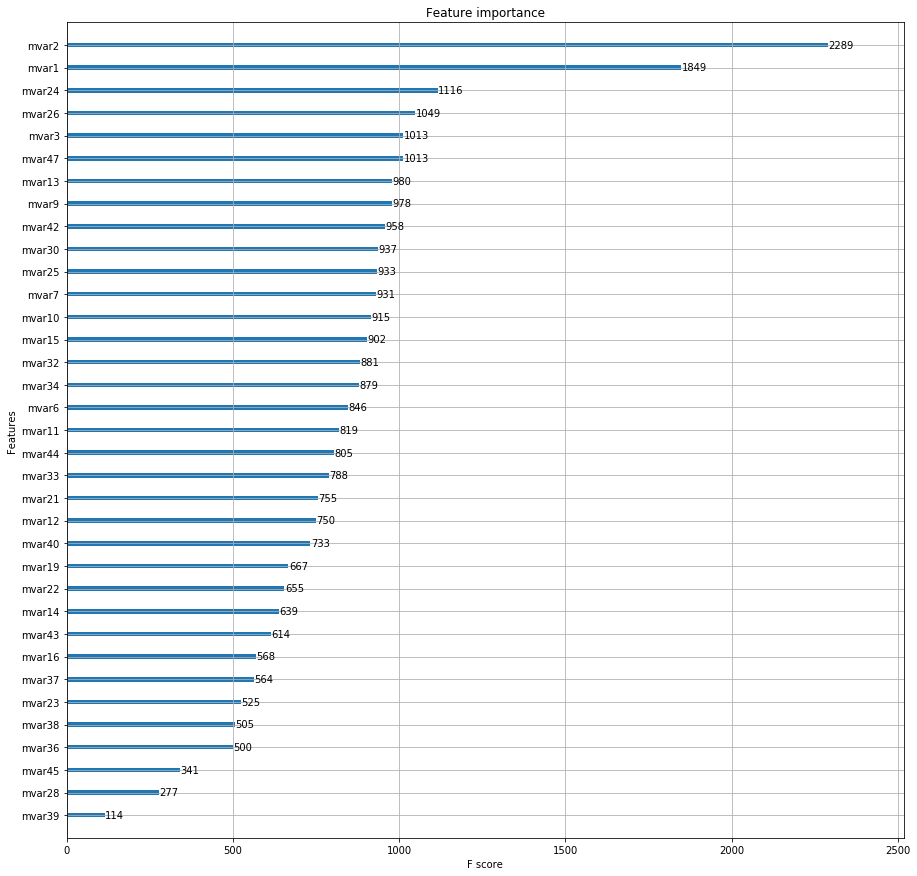

In [417]:
model(train, test)

In [418]:
train_features, train_target, test_features = preparing_data(train, test)
# xgb = XGBClassifier(n_estimators= 1000, seed=100)

xgb = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb.fit(train_features, train_target)
submission = pd.concat([test["application_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["0","1"])], axis=1)

In [419]:
# xgb.predict_proba(test_features)
test_features.shape

(25000, 35)

In [420]:
submission_pred = xgb.predict(test_features)

In [421]:
submission_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [422]:
submission.head()

,application_key,0,1
0,350053.0,0.954856,0.045144
1,350054.0,0.942061,0.057938
2,350055.0,0.840843,0.159157
3,350056.0,0.357051,0.642949
4,350057.0,0.881590,0.118410


In [236]:
# Y_pred=xgb1.predict(X_test)

In [23]:
# xgb1.predict_proba(X_test)

In [24]:
# float(np.sum(Y_pred == Y_test))/float(np.sum(Y_test == Y_test))

In [25]:
# metrics.accuracy_score(Y_test, Y_pred)

In [26]:
# X_lead = pd.read_csv('./RefinedData/refined_leaderboard_data.csv', low_memory=False)

In [27]:
# X_lead.head()

In [28]:
# Y_lead=pd.DataFrame(xgb1.predict(X_lead))

In [29]:
# Y_prob = xgb1.predict_proba(X_lead)
# Y_prob

In [423]:
submission

,application_key,0,1
0,350053.0,0.954856,0.045144
1,350054.0,0.942061,0.057938
2,350055.0,0.840843,0.159157
3,350056.0,0.357051,0.642949
4,350057.0,0.881590,0.118410
5,350058.0,0.991823,0.008177
6,350059.0,0.939831,0.060169
7,350060.0,0.995080,0.004920
8,350061.0,0.992675,0.007325
9,350062.0,0.733048,0.266952


In [424]:
# Y_wt = Y_prob[:,0]
Y_wt = submission.values[:, 1]
#Y_wt = np.abs(Y_wt - 0.5)
Y_wt

array([0.95485574, 0.94206148, 0.8408432 , ..., 0.88992214, 0.96603602,
       0.98653001])

In [425]:
sol = pd.DataFrame()
sol['priority'] = pd.Series(Y_wt)
sol['application_key'] = submission['application_key'].astype(dtype='int')
sol['default_ind'] = submission_pred.astype(dtype='int')

In [426]:
sol.head()

,priority,application_key,default_ind
0,0.954856,350053,0
1,0.942061,350054,0
2,0.840843,350055,0
3,0.357051,350056,1
4,0.881590,350057,0


In [427]:
sol = sol.sort_values(by = 'priority', ascending = False)

In [428]:
sol = sol.drop('priority', axis = 1)
sol.to_csv(path_or_buf='Analyzing_IITGuwahati_54.csv', index = False, header=False)